# Linking Languages

To create the graph between countries, one of the parameters which could link countries is the language. One could then decide to have a binary parameter : different or same language. However, many languages share a phylogeny, a same root and are more or less linked. Dutch and German for example share a similarity which French and German don't. That is why we wanted to define a distance between the different languages. As this did not exist is any opensource database we decided to create one ourselves from the genealogic tree of the different languages which can be found here http://glottolog.org/glottolog/family. Using the different trees for all high level families, we were able to load them using the Phyloxml library in biopython. From that we exported the tree as a graph in networkx and were then able to compute the shortest path between all languages of one family. This was done iterably through all the major families all the while filling out a dataframe of distances between the different languages. 

In [1]:
import pandas as pd
import json
from matplotlib import pyplot as plt
import networkx as nx
from scipy import spatial
import numpy as np
from Bio import Phylo
import re
import os
from tqdm import tqdm
import nltk
from nltk.metrics import edit_distance

%matplotlib inline

# 1. Computing the distance between languages

In [2]:
# Function to get the list of all official languages
def get_all_languages(df):
    languages = list()

    for lang in df.languages.tolist():
        languages.append(lang)

    languages = sum(languages, [])
    languages = list(set(languages))
    return languages

# Function to get the name which corresponds the closest to the input languages
def find_closest_lang(lang, lang_list):
    
    dist = [edit_distance(lang,x) for x in lang_list]
    return lang_list[dist.index(min(dist))]
        
# Function used to match the list of languages
def match_languages(filename, country_languages,languages, simp_languages, do_prints = False):
    match = dict()
    idx_match = dict()
    bad_match = dict()
    no_match = list()

    for lang in country_languages:
        
        match1 = [x for x in simp_languages if lang == x]
        if not len(match1):
            match1 = [x for x in simp_languages if lang+"ic" == x]
        if not len(match1):
            match1 = [x for x in simp_languages if lang+"n" == x]

        match2 = [x for x in simp_languages if lang in x]
        if len(match1):
            match.update({lang: [simp_languages.index(match1[0]), match1[0], languages[simp_languages.index(match1[0])], lang]})
        # This portion of code was removed in order to improve the accuracy of the mapping. In practice the names
        # of the languages were manually modified so that they would match in both databases.
        #elif not len(match1) and len(match2):
            #if len(match2) == 1:
            #    match.update({lang: [simp_languages.index(match2[0]), match2[0], languages[simp_languages.index(match2[0])], lang]})
            
            #elif len(match2)>1 :
            #    closest_lang = find_closest_lang(lang, match2)
            #    match.update({lang: [simp_languages.index(closest_lang), closest_lang, languages[simp_languages.index(closest_lang)], lang]})
            #else:
            #    bad_match.update({lang: match2})
        else:
            no_match.append(lang)

    if do_prints : 
        print("Bad match ({}): ".format(len(bad_match)), bad_match)
        print()
        print("No match at all ({}): ".format(len(no_match)), no_match)
    
    return match, bad_match, no_match


# Load the phylogeny trees and return the graph and list of languages
def load_tree(filename, country_languages, vis_adj = False):
    tree = Phylo.read(filename, 'newick')
    # convert the tree to a networkx graph
    net = Phylo.to_networkx(tree)
    
    # Visualize the adjacency matrix if desired
    if vis_adj:
        A = nx.adjacency_matrix(net)
        plt.spy(A.todense(),  markersize=1)
        plt.show()
        
    # Get the different languages from the network nodes
    languages = [[x, x.name] for x in net.nodes()]
    # Remove the language codes 
    simp_languages =  [re.sub(r'\[.*$', '', x[1]) for x in languages]
    simp_languages =  [re.sub(r'\{.*$', '', x) for x in simp_languages]
    simp_languages = [re.sub(r' +$', "", x) for x in simp_languages]
    
    return net, languages, simp_languages

# Function used to compute the distances between languages
def compute_language_dist(country_languages, phylogeny_files, lang_dist):
    do_prints = False
    all_bad_match = dict()
    all_no_match = dict()
    
    for file in tqdm(phylogeny_files):
        net, languages, simp_languages = load_tree(file, country_languages)
        
        # Match the languages from the 
        match, bad_match, no_match = match_languages(file, country_languages,languages, simp_languages)
        
        if len(bad_match):
            for elem in zip(bad_match.keys(), bad_match.values()):
                print(elem[0], elem[1])
                print()
            if do_prints : print(bad_match)
        # all_bad_match.update(bad_match)
        # all_no_match.update(no_match)
        
        p=nx.shortest_path_length(net)

        for idx1 in list(match.values()):
            for idx2 in list(match.values()):
                # idx[3] corresponding to the name of the language
                # idx[2][0] corresponding to the name of the countries
                lang_dist.loc[idx1[3], idx2[3]] = p[idx1[2][0]][idx2[2][0]]
    
    if do_prints : print(len(country_languages), len(match))

    return lang_dist, all_bad_match, all_no_match


In [3]:
# Loading the dataframe containing all official languages
data = pd.read_pickle(r'../DataEnriching/data.pickle')
country_languages = get_all_languages(data)

# Manually adjusting the names of certain languages
modif_dict = dict()
modif_dict.update({'Belizean Creole':"Belize Kriol English"})
modif_dict.update({'Māori':"Maori"})
modif_dict.update({'Tongan':"Rarotongan"})
modif_dict.update({'Kirundi':"Rundi"})
modif_dict.update({'Tshiluba':"Luba-Lulua"})
modif_dict.update({'Jamaican Patois':"Jamaican Creole English"})
modif_dict.update({'Hassaniya':'Hassaniyya'})
modif_dict.update({'Slovene':'Slovenian'})
modif_dict.update({'Khoisan':'Afrikaans'})
modif_dict.update({'Chibarwe':'Zimbabwean Ndebele'})
modif_dict.update({'Swazi':'Swati'})
modif_dict.update({'Sorani':'Central Kurdish'})
modif_dict.update({'Northern Ndebele':'Zimbabwean Ndebele'})
modif_dict.update({'Maldivian':'Dhivehi'})
modif_dict.update({'Zimbabwean Sign Language':'Zimbabwe Sign Language'})
modif_dict.update({'Montenegrin':'Karashevski'})
modif_dict.update({'Mauritian Creole':'Morisyen'})
modif_dict.update({'Seychellois Creole':'Seselwa Creole French'})
modif_dict.update({'Kyrgyz':'Kirghiz'})
modif_dict.update({'Norfuk':'Pitcairn-Norfolk'})
modif_dict.update({'Jèrriais':'Jerriais'})
modif_dict.update({'Guernésiais':'Dgernesiais'})
modif_dict.update({'Cook Islands Māori':'Rarotongan'})
modif_dict.update({'Greenlandic':'Kalaallisut'})
modif_dict.update({'Chinese':'Mandarin Chinese'})
modif_dict.update({'Azerbaijani':'North Azerbaijani'})
modif_dict.update({'Sami':'Akkala Sami'})
modif_dict.update({'Persian':'Western Farsi'})
modif_dict.update({'Comorian':'Maore Comorian'})
modif_dict.update({'Guaraní':'Tupi-Guarani'})
modif_dict.update({'Tokelauan':'Tokelau'})
modif_dict.update({'Southern Ndebele':'Sumayela Ndebele'})
modif_dict.update({'Haitian Creole':'Plateau Haitian Creole'})

for idx in range(len(country_languages)):
    #print(val[idx])
    if country_languages[idx] in list(modif_dict.keys()):   
        country_languages[idx] = modif_dict[country_languages[idx]]  
            
country_languages = list(set(country_languages))

# Creating the language distance dataframe
lang_dist = pd.DataFrame(columns = country_languages, index = country_languages)

for lang in country_languages:
    lang_dist[lang] = np.inf

# Loading all the phylogeny files
phylogeny_files = os.listdir(os.path.join(os.getcwd(),"PhylogenyFiles"))
phylogeny_files = [os.path.join(os.getcwd(),"PhylogenyFiles",x) for x in phylogeny_files if "newick" in x]

print("There are {} high level families".format(len(phylogeny_files)))

There are 177 high level families


Computing distance between languages based on the phylogenetical trees

In [4]:
lang_dist, bad_match, no_match = compute_language_dist(country_languages, phylogeny_files, lang_dist)

lang_dist.loc['Austro-Bavarian German', :] = lang_dist.loc['German', :]+1
lang_dist.loc['Austro-Bavarian German', 'Austro-Bavarian German'] = 0


100%|██████████| 177/177 [01:38<00:00,  1.80it/s]


Determining elements which have not yet been assigned. 

In [5]:
df = lang_dist.describe().transpose()
unassigned = df.loc[df["min"] == np.inf].index.tolist()
print(len(unassigned))
print(unassigned)

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/numpy/lib/function_base.py:4392: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


7
['Hiri Motu', 'Basque', 'Tuvaluan', 'New Zealand Sign Language', 'Malagasy', 'Zimbabwe Sign Language', 'Korean']


In [6]:
lang_dist.head(20)

,Ndau,Malay,Dgernesiais,Greek,Rundi,Polish,Swiss German,Ndonga,Romanian,German,...,Zimbabwean Ndebele,Arabic,Bengali,Galician,Portuguese,Fijian,Korean,Uzbek,Jerriais,Luba-Lulua
Ndau,0.000000,inf,inf,inf,9.000000,inf,inf,10.000000,inf,inf,...,8.000000,inf,inf,inf,inf,inf,inf,inf,inf,10.000000
Malay,inf,0.000000,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,9.000000,inf,inf,inf,inf
Dgernesiais,inf,inf,0.000000,18.000000,inf,21.000000,25.000000,inf,14.000000,22.000000,...,inf,inf,23.000000,23.000000,14.000000,inf,inf,inf,2.000000,inf
Greek,inf,inf,18.000000,0.000000,inf,7.000000,11.000000,inf,10.000000,8.000000,...,inf,inf,9.000000,9.000000,16.000000,inf,inf,inf,18.000000,inf
Rundi,9.000000,inf,inf,inf,0.000000,inf,inf,13.000000,inf,inf,...,11.000000,inf,inf,inf,inf,inf,inf,inf,inf,13.000000
Polish,inf,inf,21.000000,7.000000,inf,0.000000,14.000000,inf,13.000000,11.000000,...,inf,inf,12.000000,12.000000,19.000000,inf,inf,inf,21.000000,inf
Swiss German,inf,inf,25.000000,11.000000,inf,14.000000,0.000000,inf,17.000000,9.000000,...,inf,inf,16.000000,16.000000,23.000000,inf,inf,inf,25.000000,inf
Ndonga,10.000000,inf,inf,inf,13.000000,inf,inf,0.000000,inf,inf,...,12.000000,inf,inf,inf,inf,inf,inf,inf,inf,10.000000
Romanian,inf,inf,14.000000,10.000000,inf,13.000000,17.000000,inf,0.000000,14.000000,...,inf,inf,15.000000,15.000000,12.000000,inf,inf,inf,14.000000,inf
German,inf,inf,22.000000,8.000000,inf,11.000000,9.000000,inf,14.000000,0.000000,...,inf,inf,13.000000,13.000000,20.000000,inf,inf,inf,22.000000,inf


In [7]:
lang_dist.to_pickle('dist_languages.pkl')

In [8]:
lang_dist = pd.read_pickle('dist_languages.pkl')


# 2. Computing the distance between countries from the Languages

The idea here is to take all the official languages and when two countries share one or more official languages to have a minimal distance. Otherwise, if one or more of the official languages have a non infinite distance, to compute the average of these distances and use that as the distance between the countries. If no link can be found then the distance is set to inf.

In [9]:
countries = data.ISO2.tolist()

In [10]:
official_languages = dict(zip(data.ISO2.tolist(),data.languages.tolist()))


In [11]:
for key, val in zip(official_languages.keys(), official_languages.values()):
    #print(val)
    for idx in range(len(val)):
        #print(val[idx])
        if val[idx] in list(modif_dict.keys()):   
            val[idx] = modif_dict[val[idx]]  

In [12]:
# Creating the country language distance dataframe
country_lang_dist = pd.DataFrame(columns = countries, index = countries)

for country in countries:
    # Setting the distances between countries to inf
    country_lang_dist[country] = np.inf
    # Setting the diagonal to 0
    country_lang_dist.loc[country, country] = 0

country_lang_dist.head(10)

,AW,AF,AO,AI,AX,AL,AD,AE,AR,AM,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
AW,0.000000,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AF,inf,0.000000,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AO,inf,inf,0.000000,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AI,inf,inf,inf,0.000000,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AX,inf,inf,inf,inf,0.000000,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AL,inf,inf,inf,inf,inf,0.000000,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AD,inf,inf,inf,inf,inf,inf,0.000000,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AE,inf,inf,inf,inf,inf,inf,inf,0.000000,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AR,inf,inf,inf,inf,inf,inf,inf,inf,0.000000,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AM,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.000000,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [13]:
for country1 in countries:
    for country2 in countries:
        if country1 != country2:
            
            # Check if there is an official language in common
            lang1 = official_languages[country1]
            lang2 = official_languages[country2]
            common_lang = list(set(lang1) & set(lang2))
            
            if common_lang:
                country_lang_dist.loc[country1, country2] = 0
                country_lang_dist.loc[country2, country1] = 0
                continue
                
            # Check if there are languages with non infinite distance
            else : 
                dist_langs = list()
                for lang1_ in lang1: 
                    for lang2_ in lang2:
                        dist_langs.append(lang_dist.loc[lang1_, lang2_])
                            
                dist_langs = [ x for x in dist_langs if x != np.inf]
                if len(dist_langs):
                    country_lang_dist.loc[country1, country2] = np.mean(np.array(dist_langs))

In [14]:
country_lang_dist.to_pickle('country_dist_languages.pkl')
country_lang_dist.head(20)

,AW,AF,AO,AI,AX,AL,AD,AE,AR,AM,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
AW,0.000000,17.500000,13.500000,17.500000,16.500000,12.500000,12.500000,inf,13.500000,15.000000,...,17.500000,17.500000,inf,18.500000,18.500000,17.500000,inf,15.500000,17.500000,16.500000
AF,17.500000,0.000000,20.000000,15.000000,13.000000,7.000000,16.000000,10.000000,18.000000,9.500000,...,15.000000,15.000000,inf,17.666667,21.000000,15.000000,10.000000,14.000000,15.000000,13.000000
AO,13.500000,20.000000,0.000000,23.000000,21.000000,15.000000,6.000000,inf,6.000000,17.500000,...,23.000000,23.000000,inf,20.333333,13.000000,23.000000,inf,22.000000,23.000000,21.666667
AI,17.500000,15.000000,23.000000,0.000000,12.000000,10.000000,19.000000,inf,21.000000,12.500000,...,0.000000,0.000000,inf,0.000000,24.000000,0.000000,inf,0.000000,0.000000,0.000000
AX,16.500000,13.000000,21.000000,12.000000,0.000000,8.000000,17.000000,inf,19.000000,10.500000,...,12.000000,12.000000,inf,16.000000,22.000000,12.000000,inf,11.000000,12.000000,12.000000
AL,12.500000,7.000000,15.000000,10.000000,8.000000,0.000000,11.000000,inf,13.000000,4.500000,...,10.000000,10.000000,inf,12.666667,16.000000,10.000000,inf,9.000000,10.000000,8.666667
AD,12.500000,16.000000,6.000000,19.000000,17.000000,11.000000,0.000000,inf,4.000000,13.500000,...,19.000000,19.000000,inf,16.333333,9.000000,19.000000,inf,18.000000,19.000000,17.666667
AE,inf,10.000000,inf,inf,inf,inf,inf,0.000000,inf,inf,...,inf,inf,inf,inf,inf,inf,0.000000,inf,inf,inf
AR,13.500000,18.000000,6.000000,21.000000,19.000000,13.000000,4.000000,inf,0.000000,15.500000,...,21.000000,21.000000,inf,18.333333,11.000000,21.000000,inf,20.000000,21.000000,19.666667
AM,15.000000,9.500000,17.500000,12.500000,10.500000,4.500000,13.500000,inf,15.500000,0.000000,...,12.500000,12.500000,inf,15.166667,18.500000,12.500000,inf,11.500000,12.500000,11.166667


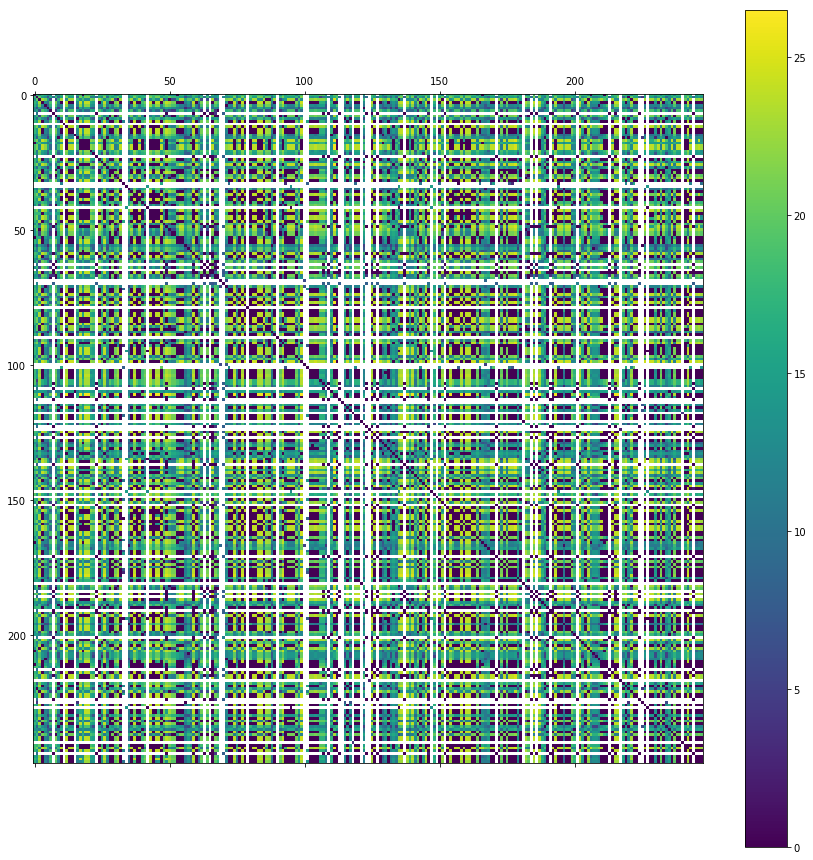

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(num = 1, figsize = (15,15))
plt.matshow(country_lang_dist, fignum = 1 )
plt.colorbar()

Khmer, Vietnamese : connected only to each other
Antartica : no language

In [16]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
stand_country_dist_languages = pd.read_pickle('./country_dist_languages.pkl')

# Standardize function : 
def stand(df):
    maxvalue = df.replace(np.inf,0.0).max().max()
    infvalreplace = 2 * maxvalue
    df.replace(np.inf,infvalreplace,inplace=True)
    myindex = df.index
    mycolumns = df.columns
    mylist = df.as_matrix()
    myshape = np.shape(mylist)
    std_scaler = StandardScaler().fit(np.array(mylist).reshape(-1, 1))
    scaled_list = std_scaler.transform(np.array(mylist).reshape(-1, 1)).reshape(myshape)   
    return pd.DataFrame(scaled_list,index=myindex,columns=mycolumns)



Standardizing the distances

In [17]:

stand_country_dist_languages = stand(stand_country_dist_languages)

# Adding the multiindex column : 
stand_country_dist_languages.columns=pd.MultiIndex.from_tuples([('language_dist',stand_country_dist_languages.columns[i]) for i in range(len(stand_country_dist_languages))])
stand_country_dist_languages.index.name = 'ISO2'
stand_country_dist_languages.to_pickle("stand_country_dist_languages.pkl")

In [18]:
stand_country_dist_languages

language_dist                                                    \
                AW        AF        AO        AI        AX        AL   
ISO2                                                                   
AW       -1.217014 -0.322308 -0.526813 -0.322308 -0.373434 -0.577939   
AF       -0.322308 -1.217014 -0.194493 -0.450123 -0.552376 -0.859132   
AO       -0.526813 -0.194493 -1.217014 -0.041115 -0.143367 -0.450123   
AI       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
AX       -0.373434 -0.552376 -0.143367 -0.603502 -1.217014 -0.808006   
AL       -0.577939 -0.859132 -0.450123 -0.705754 -0.808006 -1.217014   
AD       -0.577939 -0.398997 -0.910258 -0.245619 -0.347871 -0.654628   
AE        1.492665 -0.705754  1.492665  1.492665  1.492665  1.492665   
AR       -0.526813 -0.296745 -0.910258 -0.143367 -0.245619 -0.552376   
AM       -0.450123 -0.731317 -0.322308 -0.577939 -0.680191 -0.986947   
AS       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
AQ        1.492665  1.492665  1.492665  1.492665  1.492665  1.492665   
TF       -0.271182 -0.143367 -0.552376  0.010011 -0.092241 -0.398997   
AG       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
AU       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
AT       -0.475686 -0.552376 -0.143367 -0.705754 -0.705754 -0.808006   
AZ       -0.424560 -0.773922 -0.296745 -0.552376 -0.654628 -0.961384   
BI       -0.271182 -0.143367 -0.552376  0.010011 -0.092241 -0.398997   
BE       -1.217014 -0.398997 -0.262661 -0.450123 -0.484207 -0.654628   
BJ       -0.271182 -0.143367 -0.552376  0.010011 -0.092241 -0.398997   
BF       -0.271182 -0.143367 -0.552376  0.010011 -0.092241 -0.398997   
BD       -0.271182 -0.654628 -0.143367 -0.398997 -0.501249 -0.808006   
BG       -0.322308 -0.603502 -0.194493 -0.450123 -0.552376 -0.859132   
BH        1.492665 -0.705754  1.492665  1.492665  1.492665  1.492665   
BS       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
BA       -0.322308 -0.603502 -0.194493 -0.450123 -0.552376 -0.859132   
BL       -0.271182 -0.143367 -0.552376  0.010011 -0.092241 -0.398997   
BY       -0.424560 -0.705754 -0.296745 -0.552376 -0.654628 -0.961384   
BZ       -0.305266 -0.313787 -0.245619 -1.217014 -0.398997 -0.569418   
BM       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
...            ...       ...       ...       ...       ...       ...   
TJ       -0.271182 -0.808006 -0.143367 -0.398997 -0.501249 -0.808006   
TK       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
TM       -0.424560 -1.217014 -0.296745 -0.552376 -0.654628 -0.961384   
TL       -0.526813 -0.194493 -1.217014 -0.041115 -0.143367 -0.450123   
TO       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
TT       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
TN        1.492665 -0.705754  1.492665  1.492665  1.492665  1.492665   
TR        1.492665 -1.012510  1.492665  1.492665  1.492665  1.492665   
TV       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
TW        1.492665  1.492665  1.492665  1.492665  1.492665  1.492665   
TZ       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
UG       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
UA       -0.373434 -0.654628 -0.245619 -0.501249 -0.603502 -0.910258   
UM       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
UY       -0.526813 -0.296745 -0.910258 -0.143367 -0.245619 -0.552376   
US       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
UZ       -0.424560 -0.773922 -0.296745 -0.552376 -0.654628 -0.961384   
VA       -0.526813 -0.552376 -0.654628 -0.398997 -0.501249 -0.808006   
VC       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
VE       -0.526813 -0.296745 -0.910258 -0.143367 -0.245619 -0.552376   
VG       -0.322308 -0.450123 -0.041115 -1.217014 -0.603502 -0.705754   
VI       -0.322308 -0.450123 -0.041115 -1.217